In [5]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.7 MB/s eta 0:00:00


In [6]:
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

# Load Dataset

In [7]:
from datasets import load_dataset

dataset = load_dataset("speech_commands", "v0.01")

Generating train split:   0%|          | 0/51093 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/6799 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3081 [00:00<?, ? examples/s]

In [8]:
dataset

DatasetDict({
    train: Dataset({
        features: ['file', 'audio', 'label', 'is_unknown', 'speaker_id', 'utterance_id'],
        num_rows: 51093
    })
    validation: Dataset({
        features: ['file', 'audio', 'label', 'is_unknown', 'speaker_id', 'utterance_id'],
        num_rows: 6799
    })
    test: Dataset({
        features: ['file', 'audio', 'label', 'is_unknown', 'speaker_id', 'utterance_id'],
        num_rows: 3081
    })
})

In [9]:
sampele_audio = dataset['train']['audio'][1]['array']

In [10]:
import scipy

In [11]:
fft_audio = scipy.fft.fft(sampele_audio)

In [12]:
fft_audio.shape, fft_audio.dtype

((16000,), dtype('complex128'))

# data processingg

In [13]:
import numpy as np
np.unique(np.array(dataset['train']['label']), return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]),
 array([1860, 1853, 1843, 1842, 1839, 1852, 1864, 1839, 1885, 1861, 1866,
        1892, 1873, 1841, 1839, 1844, 1863, 1875, 1852, 1875, 1340, 1411,
        1399, 1396, 1373, 1427, 1424, 1372, 1374, 1414,    5]))

In [14]:
samp = dataset['train']['audio'][0]

In [15]:
import IPython
IPython.display.Audio(samp['array'], rate=16000)

In [16]:
# select two labels for binary classification
def filter_dataset(dataset):
    return dataset.filter(lambda x: x['label'] in [0, 1, 2, 3, 4] )


In [17]:
ds_train = filter_dataset(dataset['train'])

Filter:   0%|          | 0/51093 [00:00<?, ? examples/s]

In [18]:
ds_test = filter_dataset(dataset['test'])

Filter:   0%|          | 0/3081 [00:00<?, ? examples/s]

In [19]:
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

def process(dat):
    dat = torch.Tensor(dat)
    pad_val = max(0, 16000 - dat.shape[0])
    return torch.fft.fft(F.pad(dat, (0, pad_val))[:16000])

class CustomAudioDataset(Dataset):
    def __init__(self, hf_dataset):
        self.dataset = hf_dataset
        self.audio_column = 'audio'
        self.labels = self.dataset['label']
        # tmp_bs = self.dataset['audio']
        # self.audios = torch.Tensor([process(x['array']) for x in tmp_bs])

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        audio_data = self.dataset[idx][self.audio_column]['array']
        dat = torch.Tensor(audio_data)
        pad_val = max(0, 16000 - dat.shape[0])
        return torch.stft(F.pad(dat, (0, pad_val))[:16000], 256, return_complex=True), self.dataset[idx]['label']


'''
def collate_fn(batch):
    # Collate function to pad variable-length sequences in the batch
    audios = [item['audio'] for item in batch]
    sampling_rates = [item['sampling_rate'] for item in batch]

    # Pad sequences to have the same length
    audios = torchaudio.functional.pad_sequence(audios, batch_first=True)

    return {'audio': audios, 'sampling_rate': sampling_rates}
'''

"\ndef collate_fn(batch):\n    # Collate function to pad variable-length sequences in the batch\n    audios = [item['audio'] for item in batch]\n    sampling_rates = [item['sampling_rate'] for item in batch]\n\n    # Pad sequences to have the same length\n    audios = torchaudio.functional.pad_sequence(audios, batch_first=True)\n\n    return {'audio': audios, 'sampling_rate': sampling_rates}\n"

In [20]:
torch_train_dataset = CustomAudioDataset(ds_train)
dataloader_train = DataLoader(torch_train_dataset, batch_size=64*4, shuffle=True)

In [21]:
torch_test_dataset = CustomAudioDataset(ds_test)
dataloader_test = DataLoader(torch_test_dataset, batch_size=64*4, shuffle=True)

In [22]:
import torch

In [23]:
for f in dataloader_train:
    a = f
    break

In [24]:
a[0].shape

torch.Size([256, 129, 251])

# sample mlp

In [25]:
def l1_regularizer(model, lambda_l1=0.01):
    lossl1 = 0
    for model_param_name, model_param_value in model.named_parameters():
            if model_param_name.endswith('weight'):
                lossl1 += lambda_l1 * model_param_value.abs().sum()
    return lossl1

In [26]:
import torch.nn as nn

In [27]:

class MaxPool2d(nn.Module):
    def __init__(self, kernel_size, stride):
        super(MaxPool2d, self).__init__()
        self.kernel_size = kernel_size
        self.stride = stride

    def forward(self, x):
        batch_size, channels, height, width = x.size()

        # Calculate the output dimensions after pooling
        out_height = (height - self.kernel_size) // self.stride + 1
        out_width = (width - self.kernel_size) // self.stride + 1

        # Initialize the output tensor with zeros
        output = torch.zeros(batch_size, channels, out_height, out_width, dtype=torch.complex64).to(device)

        # Perform max pooling
        for i in range(out_height):
            for j in range(out_width):
                # Extract the local region
                region = x[:, :, i * self.stride:i * self.stride + self.kernel_size,
                              j * self.stride:j * self.stride + self.kernel_size]


                # Take the maximum value along the spatial dimensions
                idx = torch.argmax(region.abs().view(batch_size, channels, -1), dim=2, keepdim=True)
                output[:, :, i, j] = torch.gather(region.reshape(batch_size, channels, -1), 2, idx).squeeze()

        return output

In [28]:
import torchvision

In [29]:
# Example forward pass
for f in dataloader_train:
    a = f
    break

In [30]:
import torch
import torch.nn as nn

class ComplexMLP(nn.Module):
    def __init__(self, input_shape, output_size, activation=torch.nn.Sigmoid):
        super(ComplexMLP, self).__init__()

        self.input_size = input_size
        #self.hidden_sizes = hidden_sizes
        self.output_size = output_size
        self.activation = activation()

        self.act1 = activation()
        self.act2 = activation()
        self.act3 = activation()
        self.act4 = activation()

        self.resize = torchvision.transforms.Resize((32, 32), antialias=False)

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1, dtype=torch.complex64)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1, dtype=torch.complex64)
        self.pool = MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(16384, 16384 // 4, dtype=torch.complex64)
        self.fc2 = nn.Linear(16384 // 4, 16384 // 16, dtype=torch.complex64)
        self.fc3 = nn.Linear(16384 // 16, output_size, dtype=torch.complex64)

        self.norm_layer = nn.BatchNorm2d(1)

        '''
        # Input layer
        self.input_layer = nn.Linear(input_size, hidden_sizes[0], dtype=torch.complex64)

        # Hidden layers
        self.hidden_layers = nn.ModuleList([
            nn.Sequential(
                nn.Linear(in_size, out_size, dtype=torch.complex64),
                activation(),
            ) for in_size, out_size in zip(hidden_sizes, hidden_sizes[1:])
        ])

        # Output layer
        self.output_layer = nn.Linear(hidden_sizes[-1], output_size, dtype=torch.complex64)
        '''

    def forward(self, x):

        x = self.resize(x).unsqueeze(1)
        x = x #self.norm_layer(x)
        x = self.act1(self.conv1(x))
        x = self.act2(self.conv2(x))
        x = self.pool(x)
        # x = F.dropout(x, p=0.25, training=self.training)
        x = x.view(x.size(0), -1)
        x = self.act3(self.fc1(x))
        x = self.act4(self.fc2(x))
        # x = F.dropout(x, p=0.5, training=self.training)
        x = self.fc3(x)

        return x

        # # Combine real and imaginary parts into a complex number
        # input_complex = x

        # # Forward pass through the layers
        # x = self.activation(self.input_layer(input_complex))
        # for layer in self.hidden_layers:
        #     x = layer(x)
        # output_complex = self.output_layer(x)

        # return output_complex

input_size = 16000  # Assuming a 2D input (real and imaginary parts)
hidden_sizes = [4, 3]  # Two hidden layers with 4 and 3 neurons
output_size = 5

mlp = ComplexMLP(input_shape=(129, 251), output_size=output_size).to(device)


output_c = mlp(a[0].to(device))



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/_functional_tensor.py:528: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at ../aten/src/ATen/native/Copy.cpp:299.)
  img = img.to(req_dtype)


In [31]:
import torch
import torch.nn as nn

class RealMLP(nn.Module):
    def __init__(self, input_shape, output_size, activation=torch.nn.Sigmoid):
        super(RealMLP, self).__init__()

        self.input_size = input_size
        #self.hidden_sizes = hidden_sizes
        self.output_size = output_size
        self.activation = activation()

        self.act1 = activation()
        self.act2 = activation()
        self.act3 = activation()
        self.act4 = activation()

        self.resize = torchvision.transforms.Resize((32, 32), antialias=False)

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(16384, 16384 // 4)
        self.fc2 = nn.Linear(16384 // 4, 16384 // 16)
        self.fc3 = nn.Linear(16384 // 16, output_size)

        self.norm_layer = nn.BatchNorm2d(1)

        '''
        # Input layer
        self.input_layer = nn.Linear(input_size, hidden_sizes[0], dtype=torch.complex64)

        # Hidden layers
        self.hidden_layers = nn.ModuleList([
            nn.Sequential(
                nn.Linear(in_size, out_size, dtype=torch.complex64),
                activation(),
            ) for in_size, out_size in zip(hidden_sizes, hidden_sizes[1:])
        ])

        # Output layer
        self.output_layer = nn.Linear(hidden_sizes[-1], output_size, dtype=torch.complex64)
        '''

    def forward(self, x):

        x = self.resize(x.abs()).unsqueeze(1)
        x = x #self.norm_layer(x)
        x = self.act1(self.conv1(x))
        x = self.act2(self.conv2(x))
        x = self.pool(x)
        # x = F.dropout(x, p=0.25, training=self.training)
        x = x.view(x.size(0), -1)
        x = self.act3(self.fc1(x))
        x = self.act4(self.fc2(x))
        # x = F.dropout(x, p=0.5, training=self.training)
        x = self.fc3(x)

        return x

        # # Combine real and imaginary parts into a complex number
        # input_complex = x

        # # Forward pass through the layers
        # x = self.activation(self.input_layer(input_complex))
        # for layer in self.hidden_layers:
        #     x = layer(x)
        # output_complex = self.output_layer(x)

        # return output_complex

input_size = 16000  # Assuming a 2D input (real and imaginary parts)
hidden_sizes = [4, 3]  # Two hidden layers with 4 and 3 neurons
output_size = 5

mlp = ComplexMLP(input_shape=(129, 251), output_size=output_size).to(device)


output_c = mlp(a[0].to(device))



# activations


In [32]:
import torch.nn.functional as F

class SplitActivationFunction(nn.Module):
    def __init__(self, activation_func):
        super(SplitActivationFunction, self).__init__()
        self.activation_func = activation_func

    def forward(self, inp):
        # Apply the activation function separately to real and imaginary parts
        output_real = self.activation_func(inp.real)
        output_imag = self.activation_func(inp.imag)

        return output_real +  output_imag * 1j


class SplitActivationRelu(SplitActivationFunction):
    def __init__(self):
        super(SplitActivationRelu, self).__init__(F.relu)



class SplitActivationSigmoid(SplitActivationFunction):
    def __init__(self):
        super(SplitActivationSigmoid, self).__init__(F.sigmoid)

class SplitActivationTanh(SplitActivationFunction):
    def __init__(self):
        super(SplitActivationTanh, self).__init__(F.tanh)

class SplitActivationLeakyReLU(SplitActivationFunction):
    def __init__(self, negative_slope=0.01):
        super(SplitActivationLeakyReLU, self).__init__(activation_func=lambda x: F.leaky_relu(x, negative_slope=negative_slope))

class SplitActivationELU(SplitActivationFunction):
    def __init__(self, alpha=1.0):
        super(SplitActivationELU, self).__init__(activation_func=lambda x: F.elu(x, alpha=alpha))






In [33]:
class ActivationZDivideAbsZ(nn.Module):
    def __init__(self):
        super(ActivationZDivideAbsZ, self).__init__()

    def forward(self, inp):
        # Calculate the magnitude of complex numbers
        abs_z = torch.abs(inp)

        # Handle the case where abs_z is zero to avoid division by zero
        abs_z_nonzero = torch.where(abs_z == 0, torch.ones_like(abs_z), abs_z)

        return inp / abs_z_nonzero



In [34]:
import torch
import torch.nn as nn

class SplitActivationFunctionAmpPhase(nn.Module):
    def __init__(self, activation_func):
        super(SplitActivationFunctionAmpPhase, self).__init__()
        self.activation_func = activation_func

    def forward(self, inp):
        amp = torch.abs(inp)
        phase = torch.angle(inp)

        amp_out = self.activation_func(amp)
        phase_out = self.activation_func(phase)

        return amp_out * torch.exp(1j * phase_out)


class SplitActivationAmpPhaseRelu(SplitActivationFunctionAmpPhase):
    def __init__(self):
        super(SplitActivationAmpPhaseRelu, self).__init__(activation_func=F.relu)

class SplitActivationAmpPhaseSigmoid(SplitActivationFunctionAmpPhase):
    def __init__(self):
        super(SplitActivationAmpPhaseSigmoid, self).__init__(activation_func=F.sigmoid)

class SplitActivationAmpPhaseTanh(SplitActivationFunctionAmpPhase):
    def __init__(self):
        super(SplitActivationAmpPhaseTanh, self).__init__(activation_func=F.tanh)

class SplitActivationAmpPhaseLeakyReLU(SplitActivationFunctionAmpPhase):
    def __init__(self, negative_slope=0.01):
        super(SplitActivationAmpPhaseLeakyReLU, self).__init__(activation_func=lambda x: F.leaky_relu(x, negative_slope=negative_slope))

class SplitActivationAmpPhaseELU(SplitActivationFunctionAmpPhase):
    def __init__(self, alpha=1.0):
        super(SplitActivationAmpPhaseELU, self).__init__(activation_func=lambda x: F.elu(x, alpha=alpha))




In [35]:
class ReLUOnMagnitude(nn.Module):
    def __init__(self):
        super(ReLUOnMagnitude, self).__init__()
        self.magnitude_activation = nn.ReLU()
        self.trainable_bias = nn.Parameter(torch.ones(1))  # Trainable bias parameter

    def forward(self, inp):
        # Calculate the magnitude and phase of complex numbers
        magnitude = torch.abs(inp)
        phase = torch.angle(inp)

        # Apply ReLU to the magnitude and preserve the phase
        amp_out = self.magnitude_activation(magnitude + self.trainable_bias)

        return amp_out * torch.exp(1j * phase)

class CardioidActivation(nn.Module):
    def forward(self, z):
        angle = torch.angle(z)
        return 0.5 * (1 + torch.cos(angle)) * z

# Train

In [36]:
from tqdm.notebook import tqdm

In [37]:
input_size = 16000
hidden_sizes = [1000, 500]
output_size = 5

mlp = ComplexMLP(input_shape=(129, 251), output_size=output_size)

In [38]:
'''
n_epochs = 10
model = mlp.to(device)
loss = torch.nn.CrossEntropyLoss()
lss = []

optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0)
# torch.optim.Adam(model.parameters()) #

for i in tqdm(range(n_epochs)):
    cnt = 0
    for X, y in tqdm(dataloader_train):
        y_preds = model(X.to(device)).to('cpu').abs()
        ls1 = loss(y_preds, y)
        ls2 = 0 # l1_regularizer(model, 0.01)

        ls = ls1 + ls2

        lss.append(ls.item())
        ls.backward()
        optimizer.step()
        optimizer.zero_grad()

        if cnt % 10 == 0:
            print(lss[-1], end = ' ')

    print()
    print(f'epoch {i} loss: {ls.item()}')
'''


"\nn_epochs = 10\nmodel = mlp.to(device)\nloss = torch.nn.CrossEntropyLoss()\nlss = []\n\noptimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0)\n# torch.optim.Adam(model.parameters()) #\n\nfor i in tqdm(range(n_epochs)):\n    cnt = 0\n    for X, y in tqdm(dataloader_train):\n        y_preds = model(X.to(device)).to('cpu').abs()\n        ls1 = loss(y_preds, y)\n        ls2 = 0 # l1_regularizer(model, 0.01)\n\n        ls = ls1 + ls2\n\n        lss.append(ls.item())\n        ls.backward()\n        optimizer.step()\n        optimizer.zero_grad()\n        \n        if cnt % 10 == 0:\n            print(lss[-1], end = ' ')\n\n    print()\n    print(f'epoch {i} loss: {ls.item()}')\n"

In [39]:
def calc_ema(x, alpha):
    ans = []
    ma = x[0]
    alpha = max(0, min(1, alpha))
    for i in range(1, len(x)):
        ma = (alpha) * x[i] + (1 - alpha) * ma
        ans.append(ma)
    return ans

# Checking multiple different activations

In [40]:
import torch
import torch.nn.functional as F
from tqdm.notebook import tqdm

def train_and_evaluate(model, train_dataset, test_dataset, n_epochs, optimizer, loss_fn=torch.nn.CrossEntropyLoss(), print_interval=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []
    detailed_losses = []
    cnt = 0
    train_loss = 0.0
    correct_train = 0
    total_train = 0

    for epoch in tqdm(range(n_epochs)):
        model.train()


        for inputs, labels in tqdm(train_dataloader):
            cnt += 1
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs).real #.abs()
            loss = loss_fn(outputs, labels)

            loss.backward()
            optimizer.step()

            detailed_losses.append(loss.item())
            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

            if cnt % print_interval == 0:
                avg_train_loss = train_loss / cnt
                train_accuracy = correct_train / total_train
                train_losses.append(avg_train_loss)
                train_accuracies.append(train_accuracy)

                print(f"Train Loss: {avg_train_loss}, Train Accuracy: {train_accuracy}")

                train_loss = 0.0
                correct_train = 0
                total_train = 0
                cnt = 0





        # Validation
        model.eval()
        test_loss = 0.0
        correct_test = 0
        total_test = 0

        with torch.no_grad():
            for inputs, labels in tqdm(test_dataloader):
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs).real #.abs()
                loss = loss_fn(outputs, labels)
                test_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_test += labels.size(0)
                correct_test += (predicted == labels).sum().item()

            avg_test_loss = test_loss / len(test_dataloader)
            test_accuracy = correct_test / total_test
            test_losses.append(avg_test_loss)
            test_accuracies.append(test_accuracy)

            if epoch % print_interval == 0:
                print(f"Epoch {epoch}, Test Loss: {avg_test_loss}, Test Accuracy: {test_accuracy}")

    return model, train_losses, test_losses, train_accuracies, test_accuracies, detailed_losses



In [45]:
activ_possibs = [
    # SplitActivationRelu,
    # SplitActivationSigmoid,
    # SplitActivationTanh,
    # SplitActivationLeakyReLU,
    # SplitActivationELU,
    ActivationZDivideAbsZ,
    SplitActivationAmpPhaseRelu,
    SplitActivationAmpPhaseSigmoid,
    SplitActivationAmpPhaseTanh,
    SplitActivationAmpPhaseLeakyReLU,
    SplitActivationAmpPhaseELU,
    ReLUOnMagnitude,
    torch.nn.Sigmoid,
    CardioidActivation,
]

activ_possibs = [
    CardioidActivation,
    SplitActivationRelu
]


posib_names = [
    # 'SARelu',
    # 'SASigmoid',
    # 'SATanh',
    # 'SALeakyReLU',
    # 'SAELU',
    'ZDivideAbsZ',
    'SA_AmpPhRelu',
    'SA_AmpPhSigmoid',
    'SA_AmpPhTanh',
    'SA_AmpPhLeakyrelu',
    'SA_AmpPhElu',
    'ReLUOnMagnitude',
    'Sigmoid'
]

results = []



In [42]:
input_size = 16000
output_size = 5



In [43]:
for activ_fn in tqdm(activ_possibs):
    mlp = RealMLP(input_shape=(129, 251), output_size=output_size, activation=activ_fn)
    n_epochs = 5
    model = mlp.to(device)
    loss = torch.nn.CrossEntropyLoss()
    lss = []

    optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.1)
    #optimizer = torch.optim.Adam(model.parameters()) #


    rs = train_and_evaluate(model, torch_train_dataset, torch_test_dataset, n_epochs, optimizer, loss_fn=torch.nn.CrossEntropyLoss(), print_interval=10)
    results.append(rs[1:])

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/289 [00:00<?, ?it/s]

Train Loss: 1.60814288854599, Train Accuracy: 0.209375
Train Loss: 1.6097681045532226, Train Accuracy: 0.2
Train Loss: 1.6077944874763488, Train Accuracy: 0.25625
Train Loss: 1.6063406229019166, Train Accuracy: 0.225
Train Loss: 1.6069465637207032, Train Accuracy: 0.18125
Train Loss: 1.6040651082992554, Train Accuracy: 0.25625
Train Loss: 1.6051697850227356, Train Accuracy: 0.221875
Train Loss: 1.6042977571487427, Train Accuracy: 0.246875
Train Loss: 1.6051071405410766, Train Accuracy: 0.259375
Train Loss: 1.6048569083213806, Train Accuracy: 0.2375
Train Loss: 1.6007501840591432, Train Accuracy: 0.26875
Train Loss: 1.6019228935241698, Train Accuracy: 0.240625
Train Loss: 1.5998957753181458, Train Accuracy: 0.259375
Train Loss: 1.5999197125434876, Train Accuracy: 0.221875
Train Loss: 1.6030973553657533, Train Accuracy: 0.2375
Train Loss: 1.598856508731842, Train Accuracy: 0.2875
Train Loss: 1.5998445272445678, Train Accuracy: 0.240625
Train Loss: 1.6028879046440125, Train Accuracy: 0.24

  0%|          | 0/41 [00:00<?, ?it/s]

Epoch 0, Test Loss: 1.5900676134156018, Test Accuracy: 0.3069230769230769


  0%|          | 0/289 [00:00<?, ?it/s]

Train Loss: 1.5875149369239807, Train Accuracy: 0.3268608414239482
Train Loss: 1.590315043926239, Train Accuracy: 0.265625
Train Loss: 1.590067458152771, Train Accuracy: 0.290625
Train Loss: 1.584285318851471, Train Accuracy: 0.3
Train Loss: 1.5859022378921508, Train Accuracy: 0.290625
Train Loss: 1.5838062286376953, Train Accuracy: 0.290625
Train Loss: 1.5839609861373902, Train Accuracy: 0.33125
Train Loss: 1.585321581363678, Train Accuracy: 0.28125
Train Loss: 1.5776538729667664, Train Accuracy: 0.340625
Train Loss: 1.5791664242744445, Train Accuracy: 0.315625
Train Loss: 1.581082534790039, Train Accuracy: 0.309375
Train Loss: 1.5793798804283141, Train Accuracy: 0.296875
Train Loss: 1.5885743618011474, Train Accuracy: 0.340625
Train Loss: 1.5720468521118165, Train Accuracy: 0.34375
Train Loss: 1.5771084427833557, Train Accuracy: 0.309375
Train Loss: 1.5809337139129638, Train Accuracy: 0.2875
Train Loss: 1.5796164393424987, Train Accuracy: 0.31875
Train Loss: 1.584631586074829, Train 

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/289 [00:00<?, ?it/s]

Train Loss: 1.568385088443756, Train Accuracy: 0.3365695792880259
Train Loss: 1.5703207850456238, Train Accuracy: 0.34375
Train Loss: 1.564682936668396, Train Accuracy: 0.3625
Train Loss: 1.5595962762832642, Train Accuracy: 0.4
Train Loss: 1.5651477456092835, Train Accuracy: 0.365625
Train Loss: 1.5612585306167603, Train Accuracy: 0.384375
Train Loss: 1.554981279373169, Train Accuracy: 0.3875
Train Loss: 1.555027186870575, Train Accuracy: 0.396875
Train Loss: 1.5602781295776367, Train Accuracy: 0.384375
Train Loss: 1.5634482860565186, Train Accuracy: 0.39375
Train Loss: 1.5538781523704528, Train Accuracy: 0.3875
Train Loss: 1.558992338180542, Train Accuracy: 0.365625
Train Loss: 1.5588940262794495, Train Accuracy: 0.375
Train Loss: 1.5476994514465332, Train Accuracy: 0.378125
Train Loss: 1.5517862677574157, Train Accuracy: 0.403125
Train Loss: 1.5622652530670167, Train Accuracy: 0.353125
Train Loss: 1.5442236423492433, Train Accuracy: 0.384375
Train Loss: 1.5418020963668824, Train Accu

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/289 [00:00<?, ?it/s]

Train Loss: 1.5273966550827027, Train Accuracy: 0.4401294498381877
Train Loss: 1.5455581307411195, Train Accuracy: 0.403125
Train Loss: 1.5094265460968017, Train Accuracy: 0.471875
Train Loss: 1.5209299445152282, Train Accuracy: 0.4
Train Loss: 1.5323344707489013, Train Accuracy: 0.459375
Train Loss: 1.527709686756134, Train Accuracy: 0.425
Train Loss: 1.5272486448287963, Train Accuracy: 0.36875
Train Loss: 1.5316385984420777, Train Accuracy: 0.421875
Train Loss: 1.5343254446983337, Train Accuracy: 0.4375
Train Loss: 1.528438937664032, Train Accuracy: 0.425
Train Loss: 1.5153668522834778, Train Accuracy: 0.48125
Train Loss: 1.5181251168251038, Train Accuracy: 0.44375
Train Loss: 1.513557243347168, Train Accuracy: 0.4375
Train Loss: 1.4961716055870056, Train Accuracy: 0.51875
Train Loss: 1.5133240818977356, Train Accuracy: 0.471875
Train Loss: 1.5006421327590942, Train Accuracy: 0.453125
Train Loss: 1.5056728720664978, Train Accuracy: 0.453125
Train Loss: 1.507879102230072, Train Accura

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/289 [00:00<?, ?it/s]

Train Loss: 1.4849457621574402, Train Accuracy: 0.47249190938511326
Train Loss: 1.4623615622520447, Train Accuracy: 0.4875
Train Loss: 1.4586892604827881, Train Accuracy: 0.509375
Train Loss: 1.4841168403625489, Train Accuracy: 0.4375
Train Loss: 1.4840801358222961, Train Accuracy: 0.465625
Train Loss: 1.480777096748352, Train Accuracy: 0.471875
Train Loss: 1.4776985883712768, Train Accuracy: 0.5
Train Loss: 1.4713590502738954, Train Accuracy: 0.453125
Train Loss: 1.4866861939430236, Train Accuracy: 0.471875
Train Loss: 1.4503936767578125, Train Accuracy: 0.471875
Train Loss: 1.4404403924942017, Train Accuracy: 0.5
Train Loss: 1.4461509346961976, Train Accuracy: 0.45
Train Loss: 1.4707577586174012, Train Accuracy: 0.446875
Train Loss: 1.4445130705833436, Train Accuracy: 0.484375
Train Loss: 1.4683851242065429, Train Accuracy: 0.4625
Train Loss: 1.4500056982040406, Train Accuracy: 0.503125
Train Loss: 1.445562756061554, Train Accuracy: 0.5
Train Loss: 1.4485293984413148, Train Accuracy:

  0%|          | 0/41 [00:00<?, ?it/s]

In [46]:
for activ_fn in tqdm(activ_possibs):
    mlp = ComplexMLP(input_shape=(129, 251), output_size=output_size, activation=activ_fn)
    n_epochs = 5
    model = mlp.to(device)
    loss = torch.nn.CrossEntropyLoss()
    lss = []

    optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.1)
    #optimizer = torch.optim.Adam(model.parameters()) #


    rs = train_and_evaluate(model, torch_train_dataset, torch_test_dataset, n_epochs, optimizer, loss_fn=torch.nn.CrossEntropyLoss(), print_interval=10)
    results.append(rs[1:])

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/289 [00:00<?, ?it/s]

Train Loss: 1.6081122875213623, Train Accuracy: 0.203125
Train Loss: 1.6057102918624877, Train Accuracy: 0.25
Train Loss: 1.6098236560821533, Train Accuracy: 0.21875
Train Loss: 1.608254325389862, Train Accuracy: 0.178125
Train Loss: 1.610075557231903, Train Accuracy: 0.153125
Train Loss: 1.6099422097206115, Train Accuracy: 0.2125
Train Loss: 1.6077548027038575, Train Accuracy: 0.2125
Train Loss: 1.6039887547492981, Train Accuracy: 0.278125
Train Loss: 1.6041942477226256, Train Accuracy: 0.265625
Train Loss: 1.6059297561645507, Train Accuracy: 0.221875
Train Loss: 1.6062554717063904, Train Accuracy: 0.23125
Train Loss: 1.6065988659858703, Train Accuracy: 0.203125
Train Loss: 1.6035252213478088, Train Accuracy: 0.25
Train Loss: 1.6061488747596742, Train Accuracy: 0.20625
Train Loss: 1.6052559733390808, Train Accuracy: 0.26875
Train Loss: 1.6073073506355287, Train Accuracy: 0.215625
Train Loss: 1.6058217763900757, Train Accuracy: 0.20625
Train Loss: 1.6030521512031555, Train Accuracy: 0.

  0%|          | 0/41 [00:00<?, ?it/s]

Epoch 0, Test Loss: 1.600250531987446, Test Accuracy: 0.2853846153846154


  0%|          | 0/289 [00:00<?, ?it/s]

Train Loss: 1.6010453581809998, Train Accuracy: 0.23948220064724918
Train Loss: 1.600454819202423, Train Accuracy: 0.275
Train Loss: 1.6012524127960206, Train Accuracy: 0.271875
Train Loss: 1.5969322085380555, Train Accuracy: 0.2875
Train Loss: 1.6012792706489563, Train Accuracy: 0.1875
Train Loss: 1.5978562593460084, Train Accuracy: 0.2625
Train Loss: 1.5985832333564758, Train Accuracy: 0.290625
Train Loss: 1.6003681063652038, Train Accuracy: 0.25625
Train Loss: 1.593270766735077, Train Accuracy: 0.303125
Train Loss: 1.5955566883087158, Train Accuracy: 0.325
Train Loss: 1.599551796913147, Train Accuracy: 0.2875
Train Loss: 1.593974196910858, Train Accuracy: 0.340625
Train Loss: 1.5936662673950195, Train Accuracy: 0.3375
Train Loss: 1.594502341747284, Train Accuracy: 0.346875
Train Loss: 1.5991007208824157, Train Accuracy: 0.253125
Train Loss: 1.5901215434074403, Train Accuracy: 0.3125
Train Loss: 1.5979269385337829, Train Accuracy: 0.259375
Train Loss: 1.5951914668083191, Train Accura

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/289 [00:00<?, ?it/s]

Train Loss: 1.588923692703247, Train Accuracy: 0.31715210355987056
Train Loss: 1.593448281288147, Train Accuracy: 0.3
Train Loss: 1.5839558720588685, Train Accuracy: 0.371875
Train Loss: 1.5939705610275268, Train Accuracy: 0.284375
Train Loss: 1.5895697832107545, Train Accuracy: 0.365625
Train Loss: 1.585977816581726, Train Accuracy: 0.3125
Train Loss: 1.5902089595794677, Train Accuracy: 0.325
Train Loss: 1.5880682110786437, Train Accuracy: 0.31875
Train Loss: 1.5932259559631348, Train Accuracy: 0.3375
Train Loss: 1.585842537879944, Train Accuracy: 0.296875
Train Loss: 1.5852553248405457, Train Accuracy: 0.321875
Train Loss: 1.5837905406951904, Train Accuracy: 0.30625
Train Loss: 1.589592170715332, Train Accuracy: 0.24375
Train Loss: 1.5843972206115722, Train Accuracy: 0.31875
Train Loss: 1.5855603575706483, Train Accuracy: 0.340625
Train Loss: 1.5856128215789795, Train Accuracy: 0.2875
Train Loss: 1.5909006476402283, Train Accuracy: 0.29375
Train Loss: 1.5810869216918946, Train Accura

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/289 [00:00<?, ?it/s]

Train Loss: 1.578065776824951, Train Accuracy: 0.32038834951456313
Train Loss: 1.5871859073638916, Train Accuracy: 0.29375
Train Loss: 1.577853798866272, Train Accuracy: 0.346875
Train Loss: 1.581228530406952, Train Accuracy: 0.346875
Train Loss: 1.5801949501037598, Train Accuracy: 0.340625
Train Loss: 1.5724149465560913, Train Accuracy: 0.34375
Train Loss: 1.5818937182426454, Train Accuracy: 0.303125
Train Loss: 1.5806431293487548, Train Accuracy: 0.340625
Train Loss: 1.5683733701705933, Train Accuracy: 0.290625
Train Loss: 1.5736153841018676, Train Accuracy: 0.3375
Train Loss: 1.577087688446045, Train Accuracy: 0.321875
Train Loss: 1.5800575733184814, Train Accuracy: 0.334375
Train Loss: 1.5801742672920227, Train Accuracy: 0.33125
Train Loss: 1.5830320119857788, Train Accuracy: 0.36875
Train Loss: 1.57136527299881, Train Accuracy: 0.3125
Train Loss: 1.5809984922409057, Train Accuracy: 0.33125
Train Loss: 1.576460075378418, Train Accuracy: 0.334375
Train Loss: 1.568486213684082, Train

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/289 [00:00<?, ?it/s]

Train Loss: 1.5639930367469788, Train Accuracy: 0.36245954692556637
Train Loss: 1.56409432888031, Train Accuracy: 0.384375
Train Loss: 1.5630708456039428, Train Accuracy: 0.34375
Train Loss: 1.560073149204254, Train Accuracy: 0.353125
Train Loss: 1.5763643264770508, Train Accuracy: 0.35625
Train Loss: 1.5588143706321715, Train Accuracy: 0.415625
Train Loss: 1.561744248867035, Train Accuracy: 0.321875
Train Loss: 1.5711039543151855, Train Accuracy: 0.321875
Train Loss: 1.574707281589508, Train Accuracy: 0.290625
Train Loss: 1.571421754360199, Train Accuracy: 0.3125
Train Loss: 1.5666569471359253, Train Accuracy: 0.3375
Train Loss: 1.5552981495857239, Train Accuracy: 0.35
Train Loss: 1.5713908076286316, Train Accuracy: 0.315625
Train Loss: 1.5618272304534913, Train Accuracy: 0.3625
Train Loss: 1.5682350158691407, Train Accuracy: 0.33125
Train Loss: 1.5692745685577392, Train Accuracy: 0.325
Train Loss: 1.556012213230133, Train Accuracy: 0.4
Train Loss: 1.5698432207107544, Train Accuracy: 

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/289 [00:00<?, ?it/s]

Train Loss: 1.6091232895851135, Train Accuracy: 0.225
Train Loss: 1.607748067378998, Train Accuracy: 0.2125
Train Loss: 1.6062436699867249, Train Accuracy: 0.240625
Train Loss: 1.6038779139518737, Train Accuracy: 0.23125
Train Loss: 1.6081501841545105, Train Accuracy: 0.175
Train Loss: 1.6060679078102111, Train Accuracy: 0.20625
Train Loss: 1.6029200315475465, Train Accuracy: 0.221875
Train Loss: 1.601380169391632, Train Accuracy: 0.259375
Train Loss: 1.6085706949234009, Train Accuracy: 0.190625
Train Loss: 1.6050276041030884, Train Accuracy: 0.2125
Train Loss: 1.605321228504181, Train Accuracy: 0.196875
Train Loss: 1.6016507148742676, Train Accuracy: 0.215625
Train Loss: 1.598340666294098, Train Accuracy: 0.284375
Train Loss: 1.598282814025879, Train Accuracy: 0.278125
Train Loss: 1.5979695558547973, Train Accuracy: 0.265625
Train Loss: 1.5997122049331665, Train Accuracy: 0.25
Train Loss: 1.5989846467971802, Train Accuracy: 0.24375
Train Loss: 1.5904128551483154, Train Accuracy: 0.315

  0%|          | 0/41 [00:00<?, ?it/s]

Epoch 0, Test Loss: 1.5871793467824051, Test Accuracy: 0.3007692307692308


  0%|          | 0/289 [00:00<?, ?it/s]

Train Loss: 1.590504026412964, Train Accuracy: 0.28802588996763756
Train Loss: 1.5916014552116393, Train Accuracy: 0.284375
Train Loss: 1.582822060585022, Train Accuracy: 0.328125
Train Loss: 1.5833363652229309, Train Accuracy: 0.340625
Train Loss: 1.5869970083236695, Train Accuracy: 0.34375
Train Loss: 1.587337613105774, Train Accuracy: 0.3375
Train Loss: 1.578984797000885, Train Accuracy: 0.353125
Train Loss: 1.5788323402404785, Train Accuracy: 0.321875
Train Loss: 1.5752934694290162, Train Accuracy: 0.34375
Train Loss: 1.5748759865760804, Train Accuracy: 0.315625
Train Loss: 1.582724964618683, Train Accuracy: 0.359375
Train Loss: 1.5739818811416626, Train Accuracy: 0.353125
Train Loss: 1.5698895692825316, Train Accuracy: 0.371875
Train Loss: 1.5800292134284972, Train Accuracy: 0.3
Train Loss: 1.5673251032829285, Train Accuracy: 0.33125
Train Loss: 1.574460744857788, Train Accuracy: 0.30625
Train Loss: 1.571765911579132, Train Accuracy: 0.353125
Train Loss: 1.5781219363212586, Train 

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/289 [00:00<?, ?it/s]

Train Loss: 1.5598021268844604, Train Accuracy: 0.3786407766990291
Train Loss: 1.560538399219513, Train Accuracy: 0.325
Train Loss: 1.5684157013893127, Train Accuracy: 0.340625
Train Loss: 1.5463514804840088, Train Accuracy: 0.365625
Train Loss: 1.5550713062286377, Train Accuracy: 0.359375
Train Loss: 1.5667731046676636, Train Accuracy: 0.30625
Train Loss: 1.5492979288101196, Train Accuracy: 0.390625
Train Loss: 1.5576059460639953, Train Accuracy: 0.30625
Train Loss: 1.5534382581710815, Train Accuracy: 0.3375
Train Loss: 1.5527725577354432, Train Accuracy: 0.36875
Train Loss: 1.556868553161621, Train Accuracy: 0.3375
Train Loss: 1.5585240721702576, Train Accuracy: 0.34375
Train Loss: 1.556655490398407, Train Accuracy: 0.2875
Train Loss: 1.547179889678955, Train Accuracy: 0.36875
Train Loss: 1.5707380533218385, Train Accuracy: 0.290625
Train Loss: 1.5478589177131652, Train Accuracy: 0.325
Train Loss: 1.5514397740364074, Train Accuracy: 0.328125
Train Loss: 1.54478360414505, Train Accura

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/289 [00:00<?, ?it/s]

Train Loss: 1.5596738934516907, Train Accuracy: 0.35275080906148865
Train Loss: 1.5531692862510682, Train Accuracy: 0.328125
Train Loss: 1.5082599759101867, Train Accuracy: 0.4125
Train Loss: 1.5429839968681336, Train Accuracy: 0.35625
Train Loss: 1.5420186519622803, Train Accuracy: 0.334375
Train Loss: 1.5377587914466857, Train Accuracy: 0.365625
Train Loss: 1.5204011440277099, Train Accuracy: 0.3875
Train Loss: 1.5282456517219543, Train Accuracy: 0.334375
Train Loss: 1.5328259825706483, Train Accuracy: 0.346875
Train Loss: 1.5366495728492737, Train Accuracy: 0.359375
Train Loss: 1.514633846282959, Train Accuracy: 0.421875
Train Loss: 1.5437678098678589, Train Accuracy: 0.38125
Train Loss: 1.5335644602775573, Train Accuracy: 0.39375
Train Loss: 1.5231897234916687, Train Accuracy: 0.353125
Train Loss: 1.5343446373939513, Train Accuracy: 0.328125
Train Loss: 1.54014390707016, Train Accuracy: 0.3625
Train Loss: 1.5358881950378418, Train Accuracy: 0.39375
Train Loss: 1.516356873512268, Tr

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/289 [00:00<?, ?it/s]

Train Loss: 1.498256540298462, Train Accuracy: 0.41423948220064727
Train Loss: 1.5392807126045227, Train Accuracy: 0.334375
Train Loss: 1.5284440159797668, Train Accuracy: 0.3875
Train Loss: 1.5175663590431214, Train Accuracy: 0.3875
Train Loss: 1.5105382204055786, Train Accuracy: 0.41875
Train Loss: 1.5108728528022766, Train Accuracy: 0.38125
Train Loss: 1.5019254326820373, Train Accuracy: 0.45625
Train Loss: 1.5059503078460694, Train Accuracy: 0.428125
Train Loss: 1.4961284160614015, Train Accuracy: 0.45
Train Loss: 1.522275948524475, Train Accuracy: 0.3625
Train Loss: 1.5159216165542602, Train Accuracy: 0.390625
Train Loss: 1.5030414819717408, Train Accuracy: 0.425
Train Loss: 1.5262737989425659, Train Accuracy: 0.384375
Train Loss: 1.4901796340942384, Train Accuracy: 0.43125
Train Loss: 1.5020368933677672, Train Accuracy: 0.4125
Train Loss: 1.4685285925865172, Train Accuracy: 0.471875
Train Loss: 1.4902726888656617, Train Accuracy: 0.384375
Train Loss: 1.4907904028892518, Train Acc

  0%|          | 0/41 [00:00<?, ?it/s]

In [47]:
(results[1][3][-1])

0.41384615384615386

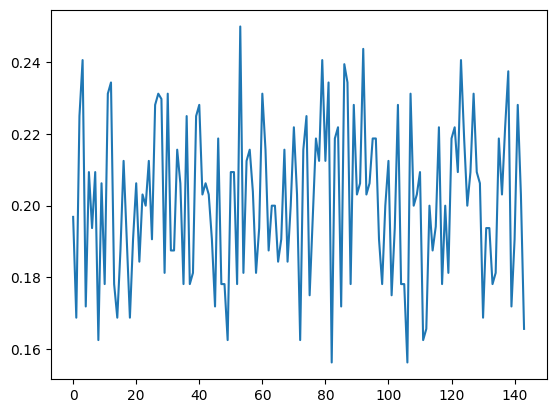

In [177]:
plt.plot(results[0][2])

In [162]:
(results[0][3][-1])

0.7415384615384616

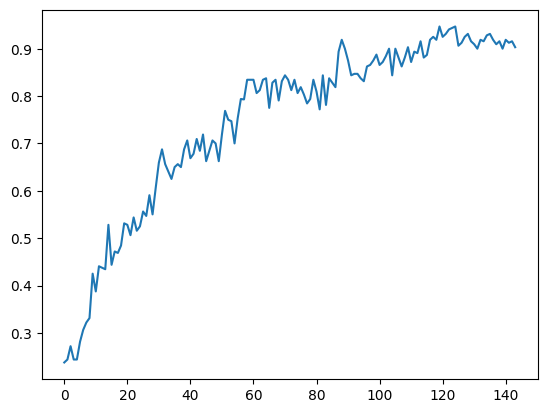

In [164]:
plt.plot(results[0][2])

In [48]:
import pickle
# Pickle the list to a file
with open('cardi_sarelu_sgd.pkl', 'wb') as file:
    pickle.dump(results, file)



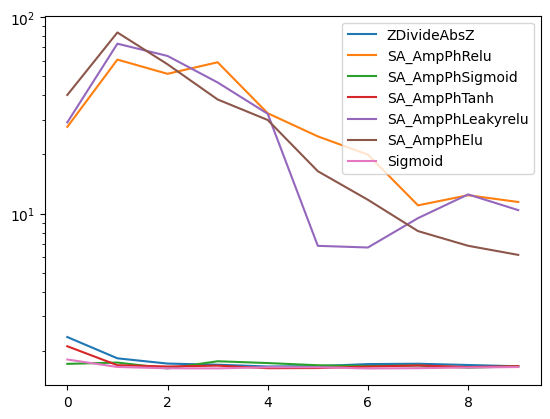

In [154]:
import matplotlib.pyplot as plt

for i in range(len(results)):
    if i == 6:
        continue
    plt.plot(results[i][0][:10], label=posib_names[i])

plt.yscale('log')
plt.legend()

In [1]:
# Load the pickled list back
with open('my_list.pkl', 'rb') as file:
    loaded_list = pickle.load(file)

print("Original List:", my_list)
print("Loaded List:", loaded_list)

FileNotFoundError: ignored